# Импорты

Импорт всех необходимых библиотек

In [3]:
%pip install -q catboost
%pip install -q optuna


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [4]:
%pip install -q shap


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRFClassifier
from sklearn.model_selection import cross_validate, cross_val_score
from shap import TreeExplainer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


In [6]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer

In [7]:
import optuna
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from optuna.samplers import RandomSampler, TPESampler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier
import catboost

In [8]:
import warnings
warnings.filterwarnings("ignore")

Импорт датасета

In [9]:
df = pd.read_csv('db_subset.csv')
df

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi,target
0,NaN,NaN,NaN,NaN,0.04,11.03,21.41,128.17,495.78,0.72,0.04,0.93,NaN,NaN,0.75,0.08,378.50,NaN,NaN,0.32,19.83,2.25,NaN,NaN,NaN,28.18,0.04,26.83,NaN,8.00,0.06,0.05,0.03,0.04,49.00,NaN,NaN,NaN,NaN,NaN,33.75,0.02,NaN,NaN,0.72,0.06,NaN,NaN,50.00,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.38,NaN,NaN,NaN,0.66,0.11,NaN,NaN,0.21,NaN,NaN,0.17,0,0,0,0,NaN,0
1,NaN,NaN,NaN,NaN,0.02,10.72,12.43,77.82,727.72,0.37,0.02,0.66,NaN,NaN,0.64,0.05,324.95,NaN,NaN,0.19,15.86,0.94,NaN,NaN,NaN,17.79,0.02,23.26,NaN,4.80,0.04,0.06,0.05,0.02,45.40,NaN,NaN,NaN,NaN,NaN,26.08,0.01,NaN,NaN,0.48,0.04,NaN,NaN,30.00,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN,0.50,NaN,NaN,NaN,1.12,0.11,NaN,NaN,0.24,NaN,NaN,0.15,0,0,0,0,NaN,0
2,NaN,NaN,NaN,NaN,0.04,25.63,19.99,147.13,373.79,0.93,0.04,1.11,NaN,NaN,1.00,0.08,354.73,NaN,NaN,0.34,25.80,4.77,NaN,NaN,NaN,28.46,0.04,29.70,NaN,8.83,0.07,0.03,0.02,0.05,37.83,NaN,NaN,NaN,NaN,NaN,35.00,0.02,NaN,NaN,0.73,0.06,NaN,NaN,53.22,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.69,NaN,NaN,NaN,0.11,0.10,NaN,NaN,0.32,NaN,NaN,0.26,1,0,0,0,NaN,0
3,NaN,NaN,NaN,0.53,0.06,4.42,NaN,2.27,0.42,NaN,0.03,0.14,0.01,0.01,0.02,0.01,2.45,NaN,0.01,0.22,0.12,NaN,NaN,NaN,0.01,NaN,0.02,0.19,NaN,0.02,0.00,0.00,0.00,0.00,0.02,0.01,0.43,NaN,NaN,0.01,1.45,0.00,NaN,0.00,0.02,0.01,NaN,0.01,NaN,0.01,0.00,0.00,0.00,NaN,0.01,NaN,NaN,0.01,0.04,NaN,0.01,NaN,0.00,0.00,NaN,NaN,0.17,NaN,NaN,0.03,0,0,0,0,NaN,0
4,NaN,NaN,NaN,1.08,0.05,1.34,NaN,2.94,1.04,NaN,0.05,0.33,0.03,0.02,0.02,0.00,5.97,NaN,0.02,0.10,0.20,NaN,NaN,NaN,0.02,NaN,0.05,0.40,NaN,0.09,0.00,0.00,0.00,0.00,0.10,0.03,0.82,NaN,NaN,0.04,3.32,0.00,NaN,0.01,0.05,0.00,NaN,0.02,NaN,0.02,NaN,0.01,0.00,NaN,0.02,NaN,NaN,0.03,0.07,NaN,0.02,0.01,0.00,0.00,NaN,NaN,0.26,NaN,NaN,0.08,0,0,0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880,30.2,67.3,42.4,477.17,24.50,1797.91,82.62,1354.90,1223.05,12.31,10.50,55.08,1.96,1.71,11.42,5.57,2305.47,17.34,0.88,56.86,760.68,2.33,0.60,15.07,1.44,163.39,9.33,217.28,8.92,466.08,1.00,1.51,2.84,0.95,218.19,3.14,182.73,62.20,0.02,2.45,961.52,0.84,0.02,0.81,11.14,4.89,0.01,1.30,109.94,1.30,1.29,0.38,3.59,60.64,1.41,0.88,6.67,2.51,10.56,181.60,113.14,4.17,4.55,0.73,9.21,24.18,60.15,68.55,6.56,4.58,1,0,0,1,35.986159,0
2881,36.1,77.1,51.6,1867.95,34.70,3373.56,81.50,2929.34,3550.36,20.59,32.17,185.21,11.50,9.37,27.31,23.95,5804.66,45.02,5.17,104.79,1344.17,8.78,0.25,31.35,8.34,270.83,28.52,534.18,7.92,5607.64,2.03,3.12,10.60,3.72,589.55,30.73,406.35,1249.62,0.33,14.14,2606.66,5.33,0.10,4.66,35.63,13.19,0.02,7.10,295.28,7.91,2.22,1.99,12.16,142.43,7.68,2.35,48.00,13.78,35.43,330.24,372.68,6.19,9.96,2.34,8.96,16.95,254.15,179.18,6.91,24.05,1,0,0,1,59.519091,1
2882,19.9,47.5,27.9,356.44,33.42,3321.43,115.59,2744.22,2027.59,34.25,17.10,103.58,5.77,4.63,26.87,42.02,5027.29,36.82,2.78,134.74,875.24,28.08,3.20,116.85,4.18,252.72,14.96,500.51,26.21,1060.56,2.15,2.15,6.73,3.05,417.65,6.31,185.98,141.09,0.33,7.05,1565.

<Axes: ylabel='Count'>

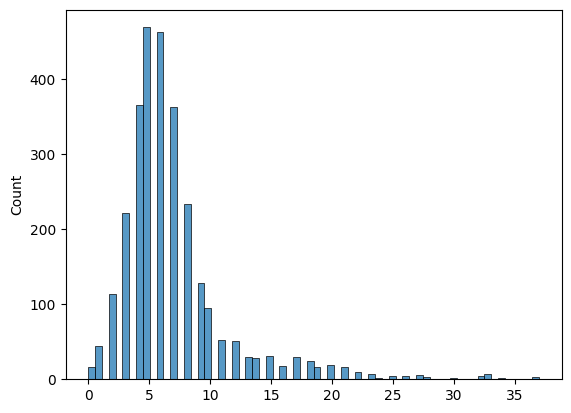

In [10]:
missing_features = df.isnull().sum(axis=1)
sns.histplot(missing_features)

# Предобработка датасета

Все признаки имеют числовой вид, посмотрим на распределение классов

In [11]:
df = df.drop(df[df['bmi']>80].index)

In [12]:
df.loc[df['target'] == 0]['target'].count(), df.loc[df['target'] == 1]['target'].count()

(1871, 1011)

<Axes: xlabel='target', ylabel='Count'>

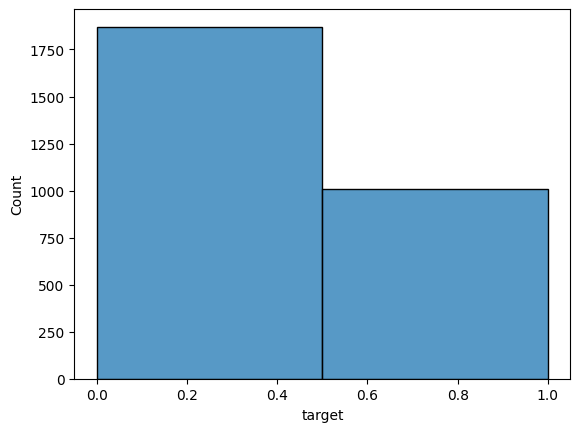

In [13]:
sns.histplot(df['target'], bins = 2)

Классы находятся в соотношении 2:1, будем считать, что они сбалансированы.

Теперь посмотрим на признаки объектов:

In [14]:
df.columns, len(df.columns)

(Index(['внутриклеточная_жидкость', 'тощая_мт', 'акм', 'холестерин', 'нас._жир',
        'натрий_na', 'сахара', 'энергия', 'вода', 'пищ._волокна',
        'мононенас._жир', 'белки', 'аргинин', 'валин', 'зола', 'полиненас._жир',
        'калий_k', 'крахмал', 'гистидин', 'жиры', 'кальций_ca', 'алкоголь',
        'кремний_si', 'сера_s', 'изолейцин', 'углеводы', 'олеиновая_кислота',
        'магний_mg', 'фруктоза', 'a', 'b1_тиамин', 'b2_рибофлав.',
        'b5_пантотен._кис.', 'b6_пиридоксин', 'b9_фолаты', 'b12_кобаламин',
        'b4_холин', 'β-каротин', 'ретин._эквив.', 'лейцин', 'фосфор_p',
        'омега-3', 'лактоза', 'метионин', 'железо_fe', 'омега-6', 'галактоза',
        'метионин+цистеин', 'c', 'треонин', 'd', 'триптофан', 'e_α-токоферол',
        'гамма-линолен._к-та', 'фенилаланин', 'h_биотин', 'бор_b',
        'фенилаланин+тирозин', 'pp_ниацин', 'ванадий_v', 'йод_i', 'кобальт_co',
        'марганец_mn', 'медь_cu', 'молибден_mo', 'никель_ni', 'селен_se',
        'фтор_f', 'хром_

Поделим датасет на тренировочную и тестовую выборки, отнормируем их, а затем уже попробуем выбрать наиболее значимые признаки.

<Axes: xlabel='bmi', ylabel='Count'>

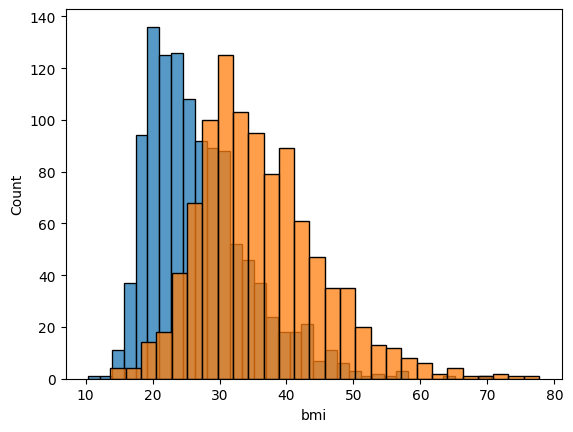

In [15]:
sns.histplot(df[df['target']==0]['bmi'], legend=True)
sns.histplot(df[df['target']==1]['bmi'], legend=True)

In [16]:
df_test = pd.concat([df[df['bmi']<35][df['bmi']>25][df['target']==0].sample(n=216),
                    df[df['bmi']<35][df['bmi']>25][df['target']==1].sample(n=216)])
df_test

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi,target
1849,NaN,70.90,42.70,890.31,78.08,2172.76,44.36,2636.34,1525.34,7.22,46.52,119.74,5.73,4.60,14.68,17.19,2568.53,13.31,3.00,167.18,1071.48,12.71,NaN,46.51,4.12,134.34,41.49,240.67,2.08,839.70,1.77,2.28,4.87,1.78,247.09,4.80,376.44,199.02,NaN,7.03,1614.45,1.45,0.01,2.33,11.20,13.78,0.03,3.48,36.27,3.79,3.48,1.05,7.37,NaN,3.74,1.31,120.00,7.00,24.48,0.20,2.76,6.91,2.23,0.86,3.55,8.35,149.52,137.24,3.54,13.31,1,0,1,0,28.680111,0
2508,20.35,47.88,31.35,522.36,34.35,2044.00,88.43,1773.63,1834.53,20.99,14.69,85.95,3.65,3.01,16.43,13.64,3426.40,22.07,1.57,79.71,1050.75,NaN,2.00,41.60,2.62,176.31,13.18,356.91,6.37,951.37,1.23,1.72,4.77,1.56,354.84,5.10,198.64,211.63,0.50,4.27,1380.37,1.44,NaN,1.43,16.81,6.08,0.04,2.16,236.77,2.37,0.86,0.66,9.96,48.27,2.38,2.81,60.00,4.21,14.46,197.44,130.90,7.43,5.54,1.24,6.14,14.03,80.90,71.79,6.41,10.79,0,1,0,1,29.765625,0
1635,NaN,NaN,NaN,828.79,44.44,4407.18,116.75,3135.32,1804.19,39.76,20.92,148.50,4.25,3.82,29.68,14.89,4832.60,133.44,1.92,111.95,1245.15,0.91,0.80,208.17,3.30,422.56,19.00,539.33,7.44,1308.29,3.08,2.69,9.28,2.79,507.96,4.93,336.24,236.00,NaN,5.53,2168.70,2.65,0.00,1.67,30.91,10.51,0.01,2.71,157.14,2.92,2.15,0.84,11.78,NaN,3.19,22.40,32.00,5.48,30.16,3.63,156.08,23.72,5.37,2.12,18.32,38.00,142.79,160.09,14.37,13.38,1,0,0,1,29.046570,0
2490,19.60,47.30,25.20,669.86,52.17,4260.91,58.87,2860.63,1674.80,21.88,49.64,169.36,9.18,6.23,24.33,30.92,3741.39,22.15,3.76,165.57,1412.28,3.17,1.71,37.36,5.64,172.09,46.71,515.75,4.41,671.82,1.21,2.83,5.38,2.21,255.90,7.68,182.19,465.00,0.06,9.76,2232.76,1.53,NaN,2.99,18.79,30.21,0.07,4.45,93.34,5.18,0.69,1.42,30.39,NaN,5.26,1.86,40.00,9.36,25.79,5.89,12.06,13.68,3.54,2.07,8.06,14.10,135.71,69.89,6.31,22.30,1,0,0,1,33.593750,0
1124,NaN,NaN,NaN,527.66,26.99,1913.41,36.01,1425.73,1536.06,18.30,23.99,99.48,6.41,5.06,20.91,16.70,3866.91,4.29,3.05,85.95,566.29,NaN,NaN,99.70,4.58,75.26,21.34,342.69,6.39,962.15,1.21,1.98,6.11,2.70,253.01,8.63,266.68,33.34,0.17,7.73,1409.96,2.53,NaN,2.49,17.97,8.74,0.03,3.61,220.10,4.23,1.24,1.15,12.49,NaN,4.00,4.51,48.00,7.18,21.82,1.90,183.40,24.30,2.14,1.54,24.39,41.49,105.08,97.64,18.35,16.46,1,0,0,1,31.790123,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
867,NaN,NaN,NaN,236.90,15.07,885.63,52.75,990.96,1140.12,9.56,8.32,41.53,2.48,1.98,7.17,12.99,1474.73,4.10,1.16,45.05,474.76,NaN,NaN,21.19,1.77,99.30,7.49,148.59,4.50,296.22,0.61,0.83,2.24,0.86,179.89,2.01,99.51,0.00,0.01,2.98,650.08,0.54,NaN,0.98,8.13,2.85,0.01,1.50,75.33,1.63,0.42,0.45,8.84,NaN,1.62,0.93,40.00,2.92,9.14,3.11,36.06,4.10,2.58,0.61,6.67,16.31,54.00,53.72,4.99,6.71,1,0,0,1,28.353057,1
1713,NaN,NaN,NaN,341.92,25.86,2172.49,79.65,1692.16,1299.86,17.79,15.00,68.37,3.42,2.75,13.07,15.61,2510.15,23.88,1.58,73.39,624.13,5.13,0.80,36.10,2.43,182.29,13.78,248.12,12.40,649.98,1.20,1.37,3.23,1.44,268.38,3.47,122.32,252.67,NaN,4.14,1050.60,1.54,NaN,1.33,14.96,8.14,0.02,2.

In [17]:
df_temp = df.drop(df_test.index)
x_temp = df_temp.drop(columns=['target'])
y_temp = df_temp['target']
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.15, random_state=42)
x_test = df_test.drop(columns=['target'])
y_test = df_test['target']

In [18]:
column_names = x_train.columns

In [19]:
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train))
x_val = pd.DataFrame(scaler.transform(x_val))
x_test = pd.DataFrame(scaler.transform(x_test))

In [20]:
column_dict = {a: column_names[a] for a in range(len(x_train.columns))}
column_dict

{0: 'внутриклеточная_жидкость',
 1: 'тощая_мт',
 2: 'акм',
 3: 'холестерин',
 4: 'нас._жир',
 5: 'натрий_na',
 6: 'сахара',
 7: 'энергия',
 8: 'вода',
 9: 'пищ._волокна',
 10: 'мононенас._жир',
 11: 'белки',
 12: 'аргинин',
 13: 'валин',
 14: 'зола',
 15: 'полиненас._жир',
 16: 'калий_k',
 17: 'крахмал',
 18: 'гистидин',
 19: 'жиры',
 20: 'кальций_ca',
 21: 'алкоголь',
 22: 'кремний_si',
 23: 'сера_s',
 24: 'изолейцин',
 25: 'углеводы',
 26: 'олеиновая_кислота',
 27: 'магний_mg',
 28: 'фруктоза',
 29: 'a',
 30: 'b1_тиамин',
 31: 'b2_рибофлав.',
 32: 'b5_пантотен._кис.',
 33: 'b6_пиридоксин',
 34: 'b9_фолаты',
 35: 'b12_кобаламин',
 36: 'b4_холин',
 37: 'β-каротин',
 38: 'ретин._эквив.',
 39: 'лейцин',
 40: 'фосфор_p',
 41: 'омега-3',
 42: 'лактоза',
 43: 'метионин',
 44: 'железо_fe',
 45: 'омега-6',
 46: 'галактоза',
 47: 'метионин+цистеин',
 48: 'c',
 49: 'треонин',
 50: 'd',
 51: 'триптофан',
 52: 'e_α-токоферол',
 53: 'гамма-линолен._к-та',
 54: 'фенилаланин',
 55: 'h_биотин',
 56: 

In [21]:
x_train = x_train.rename(columns=column_dict)
x_val = x_val.rename(columns=column_dict)
x_test = x_test.rename(columns=column_dict)
x_train

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi
0,NaN,NaN,NaN,0.642827,-0.372075,-0.353828,-0.424954,-0.230316,0.052722,-0.296484,-0.214300,-0.354227,-0.109868,-0.024245,-0.434450,0.014608,-0.357267,0.224607,-0.091510,-0.322556,-0.523950,0.151525,-0.124641,-0.465032,-0.030083,-0.235996,-0.190300,-0.388893,-0.515646,-0.132079,-0.336171,-0.260033,-0.090212,-0.190232,-0.045769,-0.220697,0.774307,0.170388,NaN,-0.047193,-0.320928,-0.180214,NaN,-0.053616,-0.300579,-0.281031,-0.501722,0.000475,-0.349594,-0.056630,0.133533,-0.028007,-0.097154,NaN,-0.007838,-0.504992,-0.108632,-0.039464,-0.294364,-0.543017,-0.136001,-0.411564,-0.288224,-0.384590,-0.445379,-0.450112,0.287768,-0.411142,-0.445868,-0.070467,1.091595,-0.276632,2.209379,-0.68203,-0.732136
1,NaN,-0.769066,NaN,0.234077,0.939558,0.284228,0.201982,0.428882,0.664208,0.129219,0.724908,0.512261,0.987208,1.001152,0.368862,0.375357,0.291217,-0.310244,1.295293,1.148500,0.109386,-0.214335,0.088487,-0.275416,1.050223,0.000543,0.708987,0.215087,0.296149,0.366823,0.701616,0.490086,0.485855,0.605246,0.297392,-0.095267,0.985373,0.026455,-0.135870,1.031900,0.338630,0.185292,NaN,1.083477,0.372013,0.288965,-0.093933,1.020868,0.492918,1.053766,0.354912,1.025265,0.260715,NaN,0.965934,-0.227405,-0.496625,1.038149,0.736795,-0.487235,0.393458,-0.081714,-0.179278,0.234033,0.205187,0.337470,0.865503,-0.029295,0.111386,0.564484,1.091595,-0.276632,-0.452616,1.46621,1.393965
2,-0.065749,-0.491450,-0.034144,0.775032,0.910028,0.890554,0.145757,0.667587,0.686413,0.669290,0.458597,1.025923,1.326779,1.464920,0.909884,0.253128,0.498279,0.442700,1.273625,0.623151,1.463847,-0.283552,-0.173483,-0.159687,1.464983,0.411829,0.442977,0.573528,0.312447,0.326239,0.596079,1.247781,0.937367,0.665854,0.937196,0.412942,0.522516,-0.509233,-0.405976,1.387861,1.026538,0.061281,-0.242123,1.361240,0.669853,0.272467,-0.229863,1.324693,0.721192,1.351927,-0.003120,1.357877,0.343435,0.448413,1.401024,-0.254790,0.040596,1.411837,0.691385,1.520751,0.650259,-0.243516,1.189477,0.573840,-0.023248,0.118607,1.329392,0.343244,-0.039223,1.199434,-0.916091,-0.276632,-0.452616,-0.68203,1.112713
3,NaN,NaN,NaN,-1.114626,-1.033312,-0.079351,0.104181,0.109847,-0.314119,1.593030,-0.634596,0.085106,-0.599634,-0.624166,0.373560,-0.466885,0.457585,2.109736,-0.705460,-0.870175,-0.373643,NaN,-0.053598,4.104987,-0.642577,1.162021,-0.585597,0.548357,-0.125734,-0.456047,1.800967,-0.260033,1.376424,0.430999,0.857827,-0.925701,-0.575400,NaN,NaN,-0.593747,-0.000761,-0.193268,NaN,-0.808784,0.857606,-0.370119,-0.365792,-0.647302,0.005981,-0.652953,-0.363886,-0.489968,-0.256142,NaN,-0.463646,4.532660,1.234420,-0.592754,0.316926,-0.485017,-0.059565,1.301271,0.226792,1.140186,-0.138518,-0.174679,0.188765,0.757164,0.213944,0.218719,-0.916091,-0.276632,-0.452616,-0.68203,NaN
4,NaN,NaN,NaN,0.392517,0.402046,0.520731,-0.058820,0.303862,0.583491,0.373106,-0.095646,0.274408,0.575805,0.609714,0.493352,0.427811,0.205403,-0.148701,0.529662,0.434646,0.497362,-0.332169,-0.182363,0.001511,0.635463,0.168767,-0.100485,0.211225,0.194596,2.073772,0.402593,0.262777,0.476513,0.271903,0.663210,-0.032551,0.407649,1.261850,NaN,0.555418,0.323123,-0.297698,NaN,0.571351,0.341852,-0.078109,-0.365792,0.6941

Видно, что в датасете есть утечки данных (значения NaN), классический Random Forest Classifier из sklearn.ensemble не может работать с такими данными, поэтому есть несколько вариантов дальнейшей работы:


1.   Работать с моделями, которые поддерживают работу с пропусками в данных
2.   Устранить пропуски при помощи Imputer-а, и обработать его классическим RF

Причем поиск оптимальных параметров для RF будет производиться при помощи GridSearchCV



## Отбор признаков ADD-DEL

In [22]:
sfs = SequentialFeatureSelector(
    XGBClassifier(),  # represents the classifier
    k_features=5,
    forward=True,
    floating=True,
    scoring="f1_macro",  # means that the selection will be decided by the accuracy of the classifier.
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
)

sfs.fit(x_train, y_train)

SequentialFeatureSelector(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                          estimator=XGBClassifier(base_score=None, booster=None,
                                                  callbacks=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  early_stopping_rounds=None,
                                                  enable_categorical=False,
                                                  eval_metric=None,
                                                  feature_types=None,
                                                  gamma=None, gpu_id=None,
                                                  grow_policy=None,
                                                  importance_...
                                                  interaction_constraints=None,
                                                  learning_rate=None,
                                                  max_bin=None,
                                                  max_cat_threshold=None,
                                                  max_cat_to_onehot=None,
                                                  max_delta_step=None,
                                                  max_depth=None,
                                                  max_leaves=None,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  n_estimators=100, n_jobs=None,
                                                  num_parallel_tree=None,
                                                  predictor=None,
                                                  random_state=None, ...),
                          floating=True, k_features=(5, 5), scoring='f1_macro')

In [23]:
df_temp = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
features_add_del = list(df_temp["feature_idx"].values[-1])
features_add_del

[0, 1, 5, 56, 74]

Для дальнейшей работы возьмем данные 5 наиболее значимых признаков.

In [24]:
x_train_add_del = x_train.iloc[:,features_add_del]
x_test_add_del = x_test.iloc[:,features_add_del]
x_test_add_del.columns

Index(['внутриклеточная_жидкость', 'тощая_мт', 'натрий_na', 'бор_b', 'bmi'], dtype='object')

<Axes: ylabel='Count'>

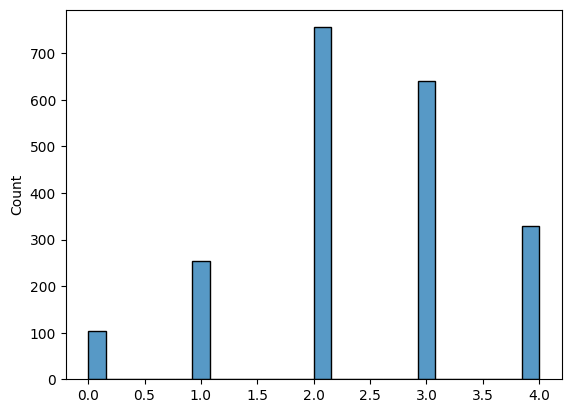

In [25]:
missing_features_add_del = x_train_add_del.isnull().sum(axis=1)
sns.histplot(missing_features_add_del)

## Отбор признаков Boruta

In [26]:
%pip install -q boruta


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [27]:
from boruta import BorutaPy

In [28]:
np.int = np.int64
np.float = np.float64
np.bool = np.bool_

In [29]:
it_imp = IterativeImputer(random_state=42)
x_train_imp = it_imp.fit_transform(x_train)
x_test_imp = it_imp.transform(x_test)

In [30]:
model = XGBClassifier()
feat_selector = BorutaPy(model, n_estimators=100, verbose=1, random_state=42)
feat_selector.fit(x_train_imp, y_train)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

BorutaPy(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                                 colsample_bylevel=None, colsample_bynode=None,
                                 colsample_bytree=None,
                                 early_stopping_rounds=None,
                                 enable_categorical=False, eval_metric=None,
                                 feature_types=None, gamma=None, gpu_id=None,
                                 grow_policy=None, importance_type=None,
                                 interaction_constraints=None,
                                 learning_rate=None, max_bin=None,
                                 max_cat_threshold=None, max_cat_to_onehot=None,
                                 max_delta_step=None, max_depth=None,
                                 max_leaves=None, min_child_weight=None,
                                 missing=nan, monotone_constraints=None,
                                 n_estimators=100, n_jobs=None,
                                 num_parallel_tree=None, predictor=None,
                                 random_state=417194910, ...),
         n_estimators=100, random_state=RandomState(MT19937) at 0x7F6EC1D52F40,
         verbose=1)

In [31]:
keep = x_train.columns[feat_selector.support_].to_list()
normal = x_train.columns[feat_selector.support_weak_].to_list()
drop = x_train.columns[
    ~(feat_selector.support_ | feat_selector.support_weak_)
].to_list()

print("features keep:", keep)
print("features normal:", normal)
print("features drop:", drop)

features keep: ['акм', 'метионин', 'профессия_работники_преимущественно_умственного_труда', 'профессия_работники_занятые_легким_физическим_трудом', 'спорт_не_занимаюсь', 'bmi']
features normal: ['внутриклеточная_жидкость', 'β-каротин', 'галактоза', 'триптофан']
features drop: ['тощая_мт', 'холестерин', 'нас._жир', 'натрий_na', 'сахара', 'энергия', 'вода', 'пищ._волокна', 'мононенас._жир', 'белки', 'аргинин', 'валин', 'зола', 'полиненас._жир', 'калий_k', 'крахмал', 'гистидин', 'жиры', 'кальций_ca', 'алкоголь', 'кремний_si', 'сера_s', 'изолейцин', 'углеводы', 'олеиновая_кислота', 'магний_mg', 'фруктоза', 'a', 'b1_тиамин', 'b2_рибофлав.', 'b5_пантотен._кис.', 'b6_пиридоксин', 'b9_фолаты', 'b12_кобаламин', 'b4_холин', 'ретин._эквив.', 'лейцин', 'фосфор_p', 'омега-3', 'лактоза', 'железо_fe', 'омега-6', 'метионин+цистеин', 'c', 'треонин', 'd', 'e_α-токоферол', 'гамма-линолен._к-та', 'фенилаланин', 'h_биотин', 'бор_b', 'фенилаланин+тирозин', 'pp_ниацин', 'ванадий_v', 'йод_i', 'кобальт_co', 'м

In [32]:
keep_ind = pd.DataFrame(x_train_imp).columns[feat_selector.support_].to_list()

## Финальный набор признаков

In [33]:
result = [i for i in x_test_add_del.columns if i in keep]
result

['bmi']

In [34]:
features_selected = list(set([*keep, *x_test_add_del.columns]))
features_selected

['профессия_работники_занятые_легким_физическим_трудом',
 'внутриклеточная_жидкость',
 'натрий_na',
 'метионин',
 'bmi',
 'тощая_мт',
 'спорт_не_занимаюсь',
 'акм',
 'бор_b',
 'профессия_работники_преимущественно_умственного_труда']

Убираем из признаков ИМТ

In [35]:
features_selected.remove('bmi')
features_selected

['профессия_работники_занятые_легким_физическим_трудом',
 'внутриклеточная_жидкость',
 'натрий_na',
 'метионин',
 'тощая_мт',
 'спорт_не_занимаюсь',
 'акм',
 'бор_b',
 'профессия_работники_преимущественно_умственного_труда']

In [36]:
features_selected_indx = []
for i in features_selected: features_selected_indx.append(list(x_train.columns).index(i))
features_selected_indx = sorted(features_selected_indx)
features_selected_indx

[0, 1, 2, 5, 43, 56, 70, 71, 73]

In [37]:
x_train_selected = x_train.iloc[:,features_selected_indx]
x_val_selected = x_val.iloc[:,features_selected_indx]
x_test_selected = x_test.iloc[:,features_selected_indx]

<Axes: ylabel='Count'>

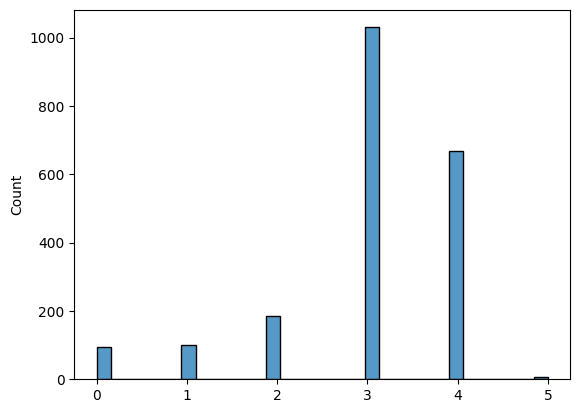

In [38]:
missing_features_selected = x_train_selected.isnull().sum(axis=1)
sns.histplot(missing_features_selected)

<Axes: ylabel='Count'>

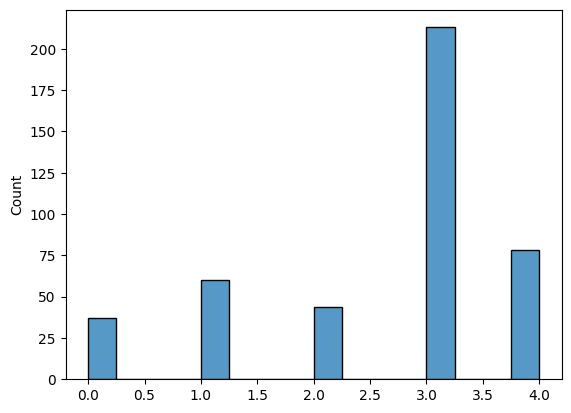

In [39]:
missing_features_selected = x_test_selected.isnull().sum(axis=1)
sns.histplot(missing_features_selected)

Видно, что в тренировочной и тестовой выборках с отобранными 9 параметрами, подавляющее большинство строк имеют 6 значимых признаков и более. Соответственно, на отобранных данных можн проводить обучение.

# Обучение моделей

Для работы с моделями будет использоваться алгоритм кросс-валидации для проверки значений метрик на тренировочной выборке, а итоговые значения метрик будут получаться на тестовой выборке.

Подбор оптимальных параметров происходит при помощи Optuna.

## 1. Рандомный лес

### 1. Imputer + RandomForest

In [40]:
it_imp = SimpleImputer(missing_values=np.nan, strategy='mean') #IterativeImputer(random_state=42)
x_train_imp = it_imp.fit_transform(x_train)
x_val_imp = it_imp.transform(x_val)
x_test_imp = it_imp.transform(x_test)

In [41]:
def param_search_rf(trial):
    params = {
        "criterion": 'log_loss',
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, 2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4, 1)
    }

    model = RandomForestClassifier(**params)
    model.fit(x_train_imp, y_train)
    predictions = model.predict(x_test_imp)
    return f1_score(y_test, predictions)

In [42]:
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(param_search_rf, n_trials=30)

[I 2024-11-24 12:07:21,031] A new study created in memory with name: no-name-2012cbbb-38a1-491f-95d8-b68f5e1483b2
[I 2024-11-24 12:07:22,867] Trial 0 finished with value: 0.34408602150537637 and parameters: {'max_depth': 3, 'n_estimators': 400, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.34408602150537637.
[I 2024-11-24 12:07:25,557] Trial 1 finished with value: 0.5225225225225226 and parameters: {'max_depth': 8, 'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.5225225225225226.
[I 2024-11-24 12:07:31,982] Trial 2 finished with value: 0.4829721362229102 and parameters: {'max_depth': 5, 'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.5225225225225226.
[I 2024-11-24 12:07:32,950] Trial 3 finished with value: 0.5105105105105106 and parameters: {'max_depth': 10, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 1 with val

In [43]:
print('Best hyperparameters:', study_rf.best_params)
print('Best ROC-AUC score:', study_rf.best_value)

Best hyperparameters: {'max_depth': 8, 'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4}
Best ROC-AUC score: 0.5406976744186047


In [44]:
rfc_best = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                  max_depth = study_rf.best_params['max_depth'],
                                  min_samples_split = study_rf.best_params['min_samples_split'],
                                  min_samples_leaf = study_rf.best_params['min_samples_leaf'],
                                  criterion='log_loss')
rfc_best.fit(x_train_imp, y_train)

RandomForestClassifier(criterion='log_loss', max_depth=8, min_samples_leaf=4,
                       n_estimators=300)

Метрики, получаемые из кросс-валидации

In [45]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(rfc_best, x_train_imp, y_train, scoring=scoring)
sorted(scores.keys())
scores

{'fit_time': array([2.13849354, 2.14829421, 2.1242249 , 2.16179323, 2.15289402]),
 'score_time': array([0.08140182, 0.06641817, 0.06627154, 0.06689978, 0.06519032]),
 'test_accuracy': array([0.81055156, 0.8177458 , 0.78846154, 0.77163462, 0.82451923]),
 'test_precision_macro': array([0.79914079, 0.79908308, 0.76886512, 0.74612284, 0.80802633]),
 'test_recall_macro': array([0.75771388, 0.77956989, 0.73589824, 0.71965906, 0.78659681]),
 'test_f1_macro': array([0.77171269, 0.78764406, 0.74723818, 0.72900138, 0.79537353]),
 'test_roc_auc': array([0.84855332, 0.88784998, 0.85152747, 0.86310082, 0.89276405])}

In [46]:
from sklearn.metrics import fbeta_score

def f2_score(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

In [47]:
def f2_score_on_pr_rec(precision, recall):
  return (5*precision*recall)/(4*precision+recall)

In [48]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
rfc_best_cv_metrics = []
for metric in metrics: rfc_best_cv_metrics.append(scores[metric])
rfc_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
rfc_best_cv_metrics = np.array(rfc_best_cv_metrics)

In [49]:
def report(y_true, y_pred):
  print(classification_report(y_true, y_pred))
  cm = confusion_matrix(y_true, y_pred, normalize="all")
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, cmap="Reds")
  print("F2-score: ", f2_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.85      0.69       216
           1       0.73      0.40      0.51       216

    accuracy                           0.62       432
   macro avg       0.66      0.62      0.60       432
weighted avg       0.66      0.62      0.60       432

F2-score:  0.43788187372708753


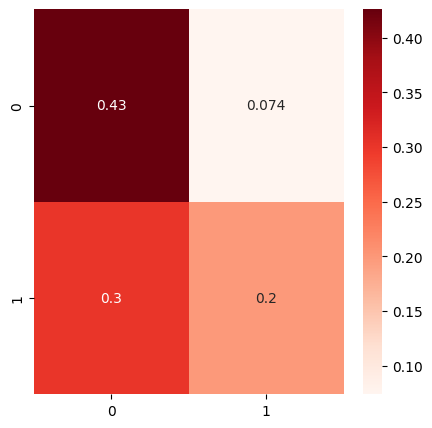

In [50]:
report(y_test, rfc_best.predict(x_test_imp))

### 2. XGBRFClassifier

In [51]:
def param_search_xgbrf(trial):
    params = {
        "criterion": 'log_loss',
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
    }

    model = XGBRFClassifier(**params)
    model.fit(x_train_selected, y_train)
    predictions = model.predict(x_test_selected)
    return f1_score(y_test, predictions)

In [52]:
study_xgbrf = optuna.create_study(direction='maximize')
study_xgbrf.optimize(param_search_xgbrf, n_trials=30)

[I 2024-11-24 12:09:14,098] A new study created in memory with name: no-name-2032fab0-251d-426d-bd1a-821aa5a435b7


[12:09:14] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:09:15,976] Trial 0 finished with value: 0.5287958115183247 and parameters: {'max_depth': 8, 'n_estimators': 1000}. Best is trial 0 with value: 0.5287958115183247.


[12:09:15] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:09:16,703] Trial 1 finished with value: 0.4903581267217631 and parameters: {'max_depth': 5, 'n_estimators': 800}. Best is trial 0 with value: 0.5287958115183247.


[12:09:16] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:09:18,048] Trial 2 finished with value: 0.5159574468085106 and parameters: {'max_depth': 7, 'n_estimators': 900}. Best is trial 0 with value: 0.5287958115183247.


[12:09:18] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:09:18,731] Trial 3 finished with value: 0.4888888888888889 and parameters: {'max_depth': 4, 'n_estimators': 1000}. Best is trial 0 with value: 0.5287958115183247.
[I 2024-11-24 12:09:18,790] Trial 4 finished with value: 0.4327485380116959 and parameters: {'max_depth': 3, 'n_estimators': 100}. Best is trial 0 with value: 0.5287958115183247.
[I 2024-11-24 12:09:18,869] Trial 5 finished with value: 0.4761904761904762 and parameters: {'max_depth': 4, 'n_estimators': 100}. Best is trial 0 with value: 0.5287958115183247.


[12:09:18] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[12:09:18] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[12:09:18] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:09:19,559] Trial 6 finished with value: 0.4888888888888889 and parameters: {'max_depth': 4, 'n_estimators': 1000}. Best is trial 0 with value: 0.5287958115183247.


[12:09:19] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:09:20,055] Trial 7 finished with value: 0.44 and parameters: {'max_depth': 3, 'n_estimators': 1000}. Best is trial 0 with value: 0.5287958115183247.


[12:09:20] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:09:20,822] Trial 8 finished with value: 0.5316455696202532 and parameters: {'max_depth': 10, 'n_estimators': 300}. Best is trial 8 with value: 0.5316455696202532.


[12:09:20] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:09:21,040] Trial 9 finished with value: 0.48467966573816157 and parameters: {'max_depth': 4, 'n_estimators': 300}. Best is trial 8 with value: 0.5316455696202532.


[12:09:21] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:09:22,309] Trial 10 finished with value: 0.5292620865139949 and parameters: {'max_depth': 10, 'n_estimators': 500}. Best is trial 8 with value: 0.5316455696202532.


[12:09:22] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:09:23,579] Trial 11 finished with value: 0.5292620865139949 and parameters: {'max_depth': 10, 'n_estimators': 500}. Best is trial 8 with value: 0.5316455696202532.


[12:09:23] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:09:24,854] Trial 12 finished with value: 0.5292620865139949 and parameters: {'max_depth': 10, 'n_estimators': 500}. Best is trial 8 with value: 0.5316455696202532.


[12:09:24] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:09:25,531] Trial 13 finished with value: 0.5374677002583979 and parameters: {'max_depth': 9, 'n_estimators': 300}. Best is trial 13 with value: 0.5374677002583979.


[12:09:25] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:09:26,088] Trial 14 finished with value: 0.5221932114882506 and parameters: {'max_depth': 8, 'n_estimators': 300}. Best is trial 13 with value: 0.5374677002583979.


[12:09:26] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:09:26,751] Trial 15 finished with value: 0.5374677002583979 and parameters: {'max_depth': 9, 'n_estimators': 300}. Best is trial 13 with value: 0.5374677002583979.


[12:09:26] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:09:28,031] Trial 16 finished with value: 0.5249343832020997 and parameters: {'max_depth': 8, 'n_estimators': 700}. Best is trial 13 with value: 0.5374677002583979.


[12:09:28] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:09:28,478] Trial 17 finished with value: 0.538860103626943 and parameters: {'max_depth': 9, 'n_estimators': 200}. Best is trial 17 with value: 0.538860103626943.


[12:09:28] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:09:28,738] Trial 18 finished with value: 0.5040650406504065 and parameters: {'max_depth': 6, 'n_estimators': 200}. Best is trial 17 with value: 0.538860103626943.


[12:09:28] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:09:29,622] Trial 19 finished with value: 0.5398457583547558 and parameters: {'max_depth': 9, 'n_estimators': 400}. Best is trial 19 with value: 0.5398457583547558.


[12:09:29] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:09:30,536] Trial 20 finished with value: 0.5173333333333334 and parameters: {'max_depth': 7, 'n_estimators': 600}. Best is trial 19 with value: 0.5398457583547558.


[12:09:30] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:09:31,425] Trial 21 finished with value: 0.5398457583547558 and parameters: {'max_depth': 9, 'n_estimators': 400}. Best is trial 19 with value: 0.5398457583547558.


[12:09:31] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:09:32,317] Trial 22 finished with value: 0.5398457583547558 and parameters: {'max_depth': 9, 'n_estimators': 400}. Best is trial 19 with value: 0.5398457583547558.


[12:09:32] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:09:33,206] Trial 23 finished with value: 0.5398457583547558 and parameters: {'max_depth': 9, 'n_estimators': 400}. Best is trial 19 with value: 0.5398457583547558.


[12:09:33] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:09:33,952] Trial 24 finished with value: 0.5157894736842105 and parameters: {'max_depth': 8, 'n_estimators': 400}. Best is trial 19 with value: 0.5398457583547558.


[12:09:33] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:09:34,870] Trial 25 finished with value: 0.5173333333333334 and parameters: {'max_depth': 7, 'n_estimators': 600}. Best is trial 19 with value: 0.5398457583547558.


[12:09:34] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:09:35,774] Trial 26 finished with value: 0.5398457583547558 and parameters: {'max_depth': 9, 'n_estimators': 400}. Best is trial 19 with value: 0.5398457583547558.


[12:09:35] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:09:36,632] Trial 27 finished with value: 0.5054347826086957 and parameters: {'max_depth': 6, 'n_estimators': 700}. Best is trial 19 with value: 0.5398457583547558.


[12:09:36] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:09:37,402] Trial 28 finished with value: 0.5157894736842105 and parameters: {'max_depth': 8, 'n_estimators': 400}. Best is trial 19 with value: 0.5398457583547558.


[12:09:37] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:09:37,852] Trial 29 finished with value: 0.5287958115183247 and parameters: {'max_depth': 8, 'n_estimators': 200}. Best is trial 19 with value: 0.5398457583547558.


In [53]:
print('Best hyperparameters:', study_xgbrf.best_params)
print('Best f1 score:', study_xgbrf.best_value)

Best hyperparameters: {'max_depth': 9, 'n_estimators': 400}
Best f1 score: 0.5398457583547558


In [54]:
xgb_rfc_best = XGBRFClassifier(criterion='log_loss', max_depth=study_xgbrf.best_params['max_depth'], n_estimators=study_xgbrf.best_params['n_estimators'])
xgb_rfc_best.fit(x_train_selected, y_train)

[12:09:37] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                criterion='log_loss', early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=9, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=400, n_jobs=None, num_parallel_tree=None,
                objective='binary:logistic', predictor=None, random_state=None, ...)

In [55]:
scoring = ['accuracy', 'roc_auc','precision_macro', 'recall_macro','f1_macro']
scores = cross_validate(xgb_rfc_best, x_train_selected, y_train, scoring=scoring)
sorted(scores.keys())

[12:09:38] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[12:09:39] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[12:09:40] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[12:09:41] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[12:09:41] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



['fit_time',
 'score_time',
 'test_accuracy',
 'test_f1_macro',
 'test_precision_macro',
 'test_recall_macro',
 'test_roc_auc']

In [56]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
xgb_rfc_best_cv_metrics = []
for metric in metrics: xgb_rfc_best_cv_metrics.append(scores[metric])
xgb_rfc_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
xgb_rfc_best_cv_metrics  = np.array( xgb_rfc_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.57      0.69      0.62       216
           1       0.61      0.49      0.54       216

    accuracy                           0.59       432
   macro avg       0.59      0.59      0.58       432
weighted avg       0.59      0.59      0.58       432

F2-score:  0.506268081002893


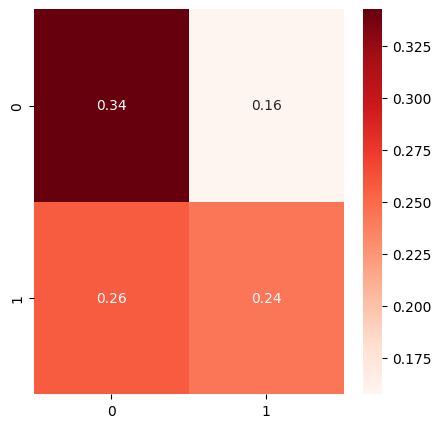

In [57]:
report(y_test, xgb_rfc_best.predict(x_test_selected))

## Бустинги

### Catboost

In [58]:
model = CatBoostClassifier(random_seed=42)

In [59]:
model.fit(
    x_train_selected,
    y_train,
    eval_set=(x_test_selected, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

Learning rate set to 0.037982
0:	learn: 0.6771327	test: 0.6918459	best: 0.6918459 (0)	total: 52.6ms	remaining: 52.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6869140377
bestIteration = 4

Shrink model to first 5 iterations.


In [60]:
f1_score(y_test, model.predict(x_test_selected))

0.4881889763779528

In [61]:
model.get_feature_importance(catboost.Pool(x_train_selected))

array([ 1.75212118, 26.26939388,  4.6317067 ,  9.26311856, 13.64804485,
       10.71604906,  0.        ,  0.        , 33.71956577])

In [62]:
def param_search_cb(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "random_strength": trial.suggest_float("random_strength", 0.5, 2.)
    }

    model = CatBoostClassifier(**params, silent=True)
    model.fit(x_train_selected, y_train)
    predictions = model.predict(x_test_selected)
    return f1_score(y_test, predictions)

In [63]:
study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(param_search_cb, n_trials=30)

[I 2024-11-24 12:09:43,248] A new study created in memory with name: no-name-bc485a90-235f-4deb-9779-d83ebcda2fc9
[I 2024-11-24 12:09:43,802] Trial 0 finished with value: 0.5125628140703519 and parameters: {'learning_rate': 0.08333962942959709, 'depth': 1, 'subsample': 0.16168932203156614, 'colsample_bylevel': 0.21965708099151654, 'min_data_in_leaf': 13, 'random_strength': 1.190954622309066}. Best is trial 0 with value: 0.5125628140703519.
[I 2024-11-24 12:09:44,722] Trial 1 finished with value: 0.5306122448979591 and parameters: {'learning_rate': 0.01684093797251421, 'depth': 4, 'subsample': 0.909447340768302, 'colsample_bylevel': 0.5838998591915798, 'min_data_in_leaf': 7, 'random_strength': 1.4570366450380543}. Best is trial 1 with value: 0.5306122448979591.
[I 2024-11-24 12:09:45,300] Trial 2 finished with value: 0.21402214022140223 and parameters: {'learning_rate': 0.0015312090548209724, 'depth': 2, 'subsample': 0.19621306061138133, 'colsample_bylevel': 0.11854672312935972, 'min_da

In [64]:
print('Best hyperparameters:', study_cb.best_params)
print('Best f1 score:', study_cb.best_value)

Best hyperparameters: {'learning_rate': 0.042616176699388546, 'depth': 4, 'subsample': 0.8209529245143105, 'colsample_bylevel': 0.24140004070864207, 'min_data_in_leaf': 58, 'random_strength': 0.8784385414118254}
Best f1 score: 0.5538461538461539


In [65]:
cb_best = CatBoostClassifier(learning_rate=study_cb.best_params['learning_rate'],
                             depth=study_cb.best_params['depth'],
                             random_seed=42,
                             subsample=study_cb.best_params['subsample'],
                             colsample_bylevel=study_cb.best_params['colsample_bylevel'],
                             min_data_in_leaf =study_cb.best_params['min_data_in_leaf'],
                             random_strength=study_cb.best_params['random_strength'])
cb_best.fit(x_train_selected, y_train)

0:	learn: 0.6762655	total: 987us	remaining: 986ms
1:	learn: 0.6666113	total: 1.97ms	remaining: 983ms
2:	learn: 0.6555912	total: 2.85ms	remaining: 947ms
3:	learn: 0.6450402	total: 3.63ms	remaining: 905ms
4:	learn: 0.6378221	total: 4.27ms	remaining: 851ms
5:	learn: 0.6274539	total: 5.17ms	remaining: 856ms
6:	learn: 0.6162022	total: 6ms	remaining: 852ms
7:	learn: 0.6097759	total: 6.87ms	remaining: 852ms
8:	learn: 0.6011475	total: 7.72ms	remaining: 850ms
9:	learn: 0.5943130	total: 8.59ms	remaining: 851ms
10:	learn: 0.5926294	total: 9.12ms	remaining: 820ms
11:	learn: 0.5887642	total: 9.74ms	remaining: 802ms
12:	learn: 0.5825550	total: 10.6ms	remaining: 805ms
13:	learn: 0.5770866	total: 11.5ms	remaining: 813ms
14:	learn: 0.5740631	total: 12.2ms	remaining: 801ms
15:	learn: 0.5692704	total: 13ms	remaining: 802ms
16:	learn: 0.5657682	total: 14ms	remaining: 807ms
17:	learn: 0.5631308	total: 14.7ms	remaining: 800ms
18:	learn: 0.5581394	total: 15.5ms	remaining: 799ms
19:	learn: 0.5558807	total: 16

In [66]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(cb_best, x_train_selected, y_train, scoring=scoring)
sorted(scores.keys())
scores

0:	learn: 0.6789781	total: 901us	remaining: 900ms
1:	learn: 0.6688070	total: 1.77ms	remaining: 884ms
2:	learn: 0.6574961	total: 2.57ms	remaining: 853ms
3:	learn: 0.6464580	total: 3.33ms	remaining: 829ms
4:	learn: 0.6369041	total: 3.91ms	remaining: 778ms
5:	learn: 0.6264034	total: 4.66ms	remaining: 771ms
6:	learn: 0.6162676	total: 5.38ms	remaining: 764ms
7:	learn: 0.6096031	total: 6.09ms	remaining: 755ms
8:	learn: 0.5999199	total: 6.79ms	remaining: 748ms
9:	learn: 0.5930941	total: 7.53ms	remaining: 746ms
10:	learn: 0.5914160	total: 7.95ms	remaining: 714ms
11:	learn: 0.5872860	total: 8.43ms	remaining: 694ms
12:	learn: 0.5814904	total: 9.08ms	remaining: 689ms
13:	learn: 0.5746057	total: 9.76ms	remaining: 687ms
14:	learn: 0.5710736	total: 10.3ms	remaining: 680ms
15:	learn: 0.5700573	total: 10.8ms	remaining: 663ms
16:	learn: 0.5670047	total: 11.5ms	remaining: 662ms
17:	learn: 0.5633045	total: 12.2ms	remaining: 663ms
18:	learn: 0.5622414	total: 12.6ms	remaining: 652ms
19:	learn: 0.5591808	to

{'fit_time': array([0.7648797 , 0.75716352, 0.76454878, 0.77003741, 0.76439786]),
 'score_time': array([0.00766921, 0.00741124, 0.0073092 , 0.00774074, 0.00743699]),
 'test_accuracy': array([0.71942446, 0.71223022, 0.75961538, 0.73317308, 0.74038462]),
 'test_precision_macro': array([0.68014475, 0.67030744, 0.73068433, 0.70183761, 0.70707071]),
 'test_recall_macro': array([0.6493299 , 0.64761571, 0.707017  , 0.65803879, 0.68168074]),
 'test_f1_macro': array([0.6569108 , 0.65405674, 0.71538041, 0.66739417, 0.68979231]),
 'test_roc_auc': array([0.75118176, 0.74681835, 0.79905641, 0.7883693 , 0.78326035])}

In [67]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
cb_best_cv_metrics = []
for metric in metrics: cb_best_cv_metrics.append(scores[metric])
cb_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
cb_best_cv_metrics = np.array(cb_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.58      0.70      0.64       216
           1       0.62      0.50      0.56       216

    accuracy                           0.60       432
   macro avg       0.60      0.60      0.60       432
weighted avg       0.60      0.60      0.60       432

F2-score:  0.5207328833172613


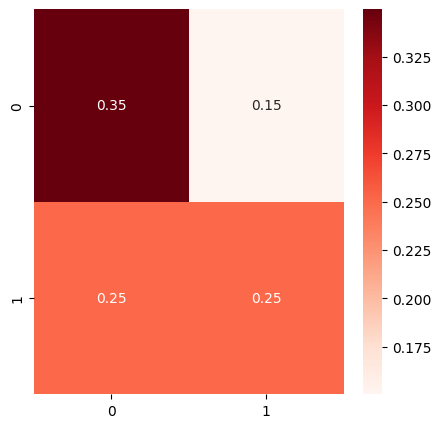

In [68]:
report(y_test, cb_best.predict(x_test_selected))

### XGBoost

In [69]:
model = XGBClassifier()

In [70]:
model.fit(
    x_train_selected,
    y_train,
    )

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [71]:
def param_search_xgb(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 100, 500),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "gamma": trial.suggest_float("gamma", 0.1, 3.)
    }

    model = XGBClassifier(**params, silent=True)
    model.fit(x_train_selected, y_train)
    predictions = model.predict(x_test_selected)
    return f1_score(y_test, predictions)

In [72]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(param_search_xgb, n_trials=30)

[I 2024-11-24 12:10:19,541] A new study created in memory with name: no-name-a400d726-cefc-4002-b6ea-c924a23a98e0


[12:10:19] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:20,739] Trial 0 finished with value: 0.5025380710659898 and parameters: {'learning_rate': 0.0650684881703943, 'max_depth': 369, 'n_estimators': 700, 'subsample': 0.33225559611924566, 'colsample_bylevel': 0.9865936191548963, 'gamma': 0.2641051594586215}. Best is trial 0 with value: 0.5025380710659898.


[12:10:20] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:21,108] Trial 1 finished with value: 0.4791666666666667 and parameters: {'learning_rate': 0.0014021093875659855, 'max_depth': 404, 'n_estimators': 500, 'subsample': 0.08342810017497171, 'colsample_bylevel': 0.5517919663167385, 'gamma': 2.6871328260338303}. Best is trial 0 with value: 0.5025380710659898.


[12:10:21] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:21,303] Trial 2 finished with value: 0.46703296703296704 and parameters: {'learning_rate': 0.004876664642848778, 'max_depth': 257, 'n_estimators': 200, 'subsample': 0.7972090469968885, 'colsample_bylevel': 0.19185182358363728, 'gamma': 0.14606776393177942}. Best is trial 0 with value: 0.5025380710659898.


[12:10:21] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:21,658] Trial 3 finished with value: 0.5357142857142857 and parameters: {'learning_rate': 0.08595284722617628, 'max_depth': 328, 'n_estimators': 400, 'subsample': 0.6222144563226443, 'colsample_bylevel': 0.09857508731870857, 'gamma': 2.155165155193924}. Best is trial 3 with value: 0.5357142857142857.


[12:10:21] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:23,205] Trial 4 finished with value: 0.5263157894736842 and parameters: {'learning_rate': 0.01791064451339889, 'max_depth': 105, 'n_estimators': 900, 'subsample': 0.6945039510319218, 'colsample_bylevel': 0.3319003344783778, 'gamma': 1.1112766585994074}. Best is trial 3 with value: 0.5357142857142857.


[12:10:23] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:23,618] Trial 5 finished with value: 0.5421994884910486 and parameters: {'learning_rate': 0.04983789139903865, 'max_depth': 132, 'n_estimators': 400, 'subsample': 0.11014164773443988, 'colsample_bylevel': 0.9922770994492741, 'gamma': 0.880359381873147}. Best is trial 5 with value: 0.5421994884910486.


[12:10:23] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:24,120] Trial 6 finished with value: 0.539440203562341 and parameters: {'learning_rate': 0.0075155092363267525, 'max_depth': 408, 'n_estimators': 700, 'subsample': 0.3386732192315239, 'colsample_bylevel': 0.19405161265126702, 'gamma': 1.6623962705703677}. Best is trial 5 with value: 0.5421994884910486.


[12:10:24] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:24,322] Trial 7 finished with value: 0.5468354430379747 and parameters: {'learning_rate': 0.045518755412800344, 'max_depth': 191, 'n_estimators': 100, 'subsample': 0.38725503699745095, 'colsample_bylevel': 0.554999666126081, 'gamma': 1.3928695578584005}. Best is trial 7 with value: 0.5468354430379747.


[12:10:24] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:24,703] Trial 8 finished with value: 0.5515463917525772 and parameters: {'learning_rate': 0.008115559071906203, 'max_depth': 137, 'n_estimators': 200, 'subsample': 0.44496103905700524, 'colsample_bylevel': 0.5387718586774306, 'gamma': 2.674555554223006}. Best is trial 8 with value: 0.5515463917525772.


[12:10:24] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:27,394] Trial 9 finished with value: 0.5213032581453634 and parameters: {'learning_rate': 0.023201878136048026, 'max_depth': 370, 'n_estimators': 900, 'subsample': 0.6457737095081543, 'colsample_bylevel': 0.6601798060067332, 'gamma': 2.5911479283569423}. Best is trial 8 with value: 0.5515463917525772.


[12:10:27] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:28,161] Trial 10 finished with value: 0.5319693094629157 and parameters: {'learning_rate': 0.0036350064417221637, 'max_depth': 497, 'n_estimators': 200, 'subsample': 0.9969015995296572, 'colsample_bylevel': 0.7821116856933126, 'gamma': 2.9887720191846587}. Best is trial 8 with value: 0.5515463917525772.
[I 2024-11-24 12:10:28,336] Trial 11 finished with value: 0.5402597402597402 and parameters: {'learning_rate': 0.01553258514205901, 'max_depth': 207, 'n_estimators': 100, 'subsample': 0.3918430232549346, 'colsample_bylevel': 0.43522212783569003, 'gamma': 1.799207882540562}. Best is trial 8 with value: 0.5515463917525772.


[12:10:28] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[12:10:28] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:28,616] Trial 12 finished with value: 0.5386533665835411 and parameters: {'learning_rate': 0.032553026710820665, 'max_depth': 181, 'n_estimators': 100, 'subsample': 0.48927681305006754, 'colsample_bylevel': 0.6728474029574664, 'gamma': 1.1531547695425235}. Best is trial 8 with value: 0.5515463917525772.


[12:10:28] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:28,996] Trial 13 finished with value: 0.5292620865139949 and parameters: {'learning_rate': 0.002188669252569767, 'max_depth': 189, 'n_estimators': 300, 'subsample': 0.23008486095339123, 'colsample_bylevel': 0.4486774228870258, 'gamma': 1.9800461857941893}. Best is trial 8 with value: 0.5515463917525772.


[12:10:29] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:29,245] Trial 14 finished with value: 0.533678756476684 and parameters: {'learning_rate': 0.009073063252309782, 'max_depth': 254, 'n_estimators': 100, 'subsample': 0.4551932682851304, 'colsample_bylevel': 0.8087156679928815, 'gamma': 2.297474243121616}. Best is trial 8 with value: 0.5515463917525772.


[12:10:29] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:29,688] Trial 15 finished with value: 0.5295629820051413 and parameters: {'learning_rate': 0.03721602908907256, 'max_depth': 154, 'n_estimators': 300, 'subsample': 0.21946250623161367, 'colsample_bylevel': 0.5776077584230723, 'gamma': 1.436167386898557}. Best is trial 8 with value: 0.5515463917525772.


[12:10:29] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:30,879] Trial 16 finished with value: 0.5343511450381679 and parameters: {'learning_rate': 0.005124149486089687, 'max_depth': 248, 'n_estimators': 600, 'subsample': 0.5438094148476984, 'colsample_bylevel': 0.35504826729991157, 'gamma': 0.6946315199865782}. Best is trial 8 with value: 0.5515463917525772.


[12:10:30] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:31,365] Trial 17 finished with value: 0.5496183206106869 and parameters: {'learning_rate': 0.011298614297521907, 'max_depth': 112, 'n_estimators': 300, 'subsample': 0.23817586892188336, 'colsample_bylevel': 0.7549518622688064, 'gamma': 1.5392427451972115}. Best is trial 8 with value: 0.5515463917525772.


[12:10:31] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:31,857] Trial 18 finished with value: 0.5482233502538071 and parameters: {'learning_rate': 0.012741123666339473, 'max_depth': 100, 'n_estimators': 300, 'subsample': 0.23238287723279838, 'colsample_bylevel': 0.8366955228120154, 'gamma': 2.5577835454891096}. Best is trial 8 with value: 0.5515463917525772.


[12:10:31] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:32,445] Trial 19 finished with value: 0.5329949238578681 and parameters: {'learning_rate': 0.00271435248939079, 'max_depth': 143, 'n_estimators': 500, 'subsample': 0.15584822712121021, 'colsample_bylevel': 0.7073684176325304, 'gamma': 1.936917912094978}. Best is trial 8 with value: 0.5515463917525772.


[12:10:32] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:33,890] Trial 20 finished with value: 0.5310173697270472 and parameters: {'learning_rate': 0.00668892788627557, 'max_depth': 288, 'n_estimators': 400, 'subsample': 0.8084462847627678, 'colsample_bylevel': 0.8548323498406316, 'gamma': 0.6158599819224212}. Best is trial 8 with value: 0.5515463917525772.


[12:10:33] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:34,422] Trial 21 finished with value: 0.5408163265306123 and parameters: {'learning_rate': 0.012853393762107338, 'max_depth': 107, 'n_estimators': 300, 'subsample': 0.26074030562333583, 'colsample_bylevel': 0.848668005094748, 'gamma': 2.510383551549538}. Best is trial 8 with value: 0.5515463917525772.


[12:10:34] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:34,796] Trial 22 finished with value: 0.5370843989769821 and parameters: {'learning_rate': 0.01087400503587041, 'max_depth': 105, 'n_estimators': 200, 'subsample': 0.27506830048127917, 'colsample_bylevel': 0.9029766012005411, 'gamma': 2.9897347682902344}. Best is trial 8 with value: 0.5515463917525772.


[12:10:34] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:35,214] Trial 23 finished with value: 0.5707070707070707 and parameters: {'learning_rate': 0.02461242222438031, 'max_depth': 139, 'n_estimators': 300, 'subsample': 0.1766477730820813, 'colsample_bylevel': 0.7443259151924737, 'gamma': 2.159234974110127}. Best is trial 23 with value: 0.5707070707070707.


[12:10:35] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:35,460] Trial 24 finished with value: 0.5426356589147286 and parameters: {'learning_rate': 0.02475666783806297, 'max_depth': 140, 'n_estimators': 200, 'subsample': 0.1276489611724828, 'colsample_bylevel': 0.7162937128447238, 'gamma': 2.3507979806369415}. Best is trial 23 with value: 0.5707070707070707.


[12:10:35] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:35,941] Trial 25 finished with value: 0.535064935064935 and parameters: {'learning_rate': 0.020222192825243318, 'max_depth': 214, 'n_estimators': 400, 'subsample': 0.15769353050846652, 'colsample_bylevel': 0.6182746017361614, 'gamma': 2.1027807892281944}. Best is trial 23 with value: 0.5707070707070707.


[12:10:35] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:36,329] Trial 26 finished with value: 0.5025125628140703 and parameters: {'learning_rate': 0.005726892014736673, 'max_depth': 163, 'n_estimators': 600, 'subsample': 0.0519186642025789, 'colsample_bylevel': 0.4678770147273986, 'gamma': 2.7796309900151606}. Best is trial 23 with value: 0.5707070707070707.


[12:10:36] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:38,628] Trial 27 finished with value: 0.5265822784810127 and parameters: {'learning_rate': 0.009842873001096372, 'max_depth': 224, 'n_estimators': 1000, 'subsample': 0.4335463308112803, 'colsample_bylevel': 0.7447461879163605, 'gamma': 1.6844462832308347}. Best is trial 23 with value: 0.5707070707070707.


[12:10:38] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:39,550] Trial 28 finished with value: 0.5363408521303259 and parameters: {'learning_rate': 0.027344292327424403, 'max_depth': 167, 'n_estimators': 300, 'subsample': 0.539581580628941, 'colsample_bylevel': 0.9097294655224986, 'gamma': 2.222191023546624}. Best is trial 23 with value: 0.5707070707070707.


[12:10:39] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:40,550] Trial 29 finished with value: 0.5510204081632653 and parameters: {'learning_rate': 0.0037775945608211634, 'max_depth': 129, 'n_estimators': 500, 'subsample': 0.3275641927117607, 'colsample_bylevel': 0.9382443494643191, 'gamma': 1.2687615284803875}. Best is trial 23 with value: 0.5707070707070707.


In [73]:
print('Best hyperparameters:', study_xgb.best_params)
print('Best f1 score:', study_xgb.best_value)

Best hyperparameters: {'learning_rate': 0.02461242222438031, 'max_depth': 139, 'n_estimators': 300, 'subsample': 0.1766477730820813, 'colsample_bylevel': 0.7443259151924737, 'gamma': 2.159234974110127}
Best f1 score: 0.5707070707070707


In [74]:
xgb_best = XGBClassifier(learning_rate=study_xgb.best_params['learning_rate'],
                         max_depth=study_xgb.best_params['max_depth'],
                         n_estimators = study_xgb.best_params['n_estimators'],
                         random_seed=42,
                         subsample=study_xgb.best_params['subsample'],
                         colsample_bylevel= study_xgb.best_params['colsample_bylevel'],
                         gamma=study_xgb.best_params['gamma'])
xgb_best.fit(x_train_selected, y_train)

[12:10:40] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.7443259151924737, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2.159234974110127, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.02461242222438031, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=139, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_seed=42, ...)

In [75]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(xgb_best, x_train_selected, y_train, scoring=scoring)
sorted(scores.keys())
scores

[12:10:40] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[12:10:41] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[12:10:41] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[12:10:41] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[12:10:42] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.



{'fit_time': array([0.32031059, 0.31378531, 0.32195425, 0.33709502, 0.31140113]),
 'score_time': array([0.01223302, 0.01250052, 0.01205707, 0.01215434, 0.01242328]),
 'test_accuracy': array([0.72422062, 0.72182254, 0.76923077, 0.75240385, 0.73076923]),
 'test_precision_macro': array([0.68617216, 0.68273616, 0.74494949, 0.73076923, 0.69443476]),
 'test_recall_macro': array([0.65840736, 0.66027739, 0.71238661, 0.67790116, 0.6744865 ]),
 'test_f1_macro': array([0.66608176, 0.66715292, 0.72296679, 0.68970287, 0.68122605]),
 'test_roc_auc': array([0.75424653, 0.75816841, 0.8011417 , 0.81169847, 0.79001147])}

In [76]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
xgb_best_cv_metrics = []
for metric in metrics: xgb_best_cv_metrics.append(scores[metric])
xgb_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
xgb_best_cv_metrics = np.array(xgb_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.59      0.69      0.64       216
           1       0.63      0.52      0.57       216

    accuracy                           0.61       432
   macro avg       0.61      0.61      0.60       432
weighted avg       0.61      0.61      0.60       432

F2-score:  0.5411877394636015


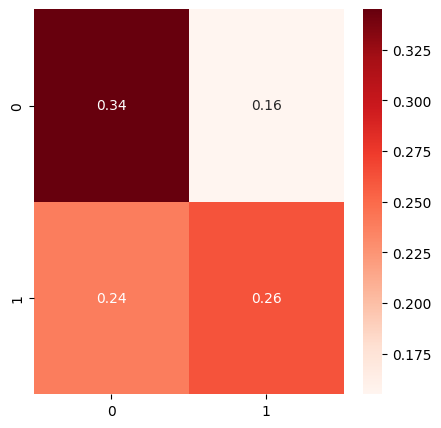

In [77]:
report(y_test, xgb_best.predict(x_test_selected))

### LightGBM

In [78]:
model = LGBMClassifier()

In [79]:
model.fit(
    x_train_selected,
    y_train,
    )

LGBMClassifier()

In [80]:
def param_search_lgbm(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 100, 500),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "gamma": trial.suggest_float("gamma", 0.1, 3.)
    }

    model = XGBClassifier(**params, silent=True)
    model.fit(x_train_selected, y_train)
    predictions = model.predict(x_test_selected)
    return f1_score(y_test, predictions)

In [81]:
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(param_search_lgbm, n_trials=30)

[I 2024-11-24 12:10:43,362] A new study created in memory with name: no-name-777bbfd8-121e-423c-887d-e1016fcaf67c
[I 2024-11-24 12:10:43,559] Trial 0 finished with value: 0.531578947368421 and parameters: {'learning_rate': 0.04485965576498642, 'max_depth': 210, 'n_estimators': 400, 'subsample': 0.1052098201870148, 'colsample_bylevel': 0.2054171968628445, 'gamma': 1.7472292151430582}. Best is trial 0 with value: 0.531578947368421.


[12:10:43] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[12:10:43] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:43,909] Trial 1 finished with value: 0.5513784461152883 and parameters: {'learning_rate': 0.03774684399875804, 'max_depth': 325, 'n_estimators': 500, 'subsample': 0.30330457825574847, 'colsample_bylevel': 0.19087278563036575, 'gamma': 1.801921985245989}. Best is trial 1 with value: 0.5513784461152883.


[12:10:43] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:45,887] Trial 2 finished with value: 0.5316455696202532 and parameters: {'learning_rate': 0.0010009313722835285, 'max_depth': 449, 'n_estimators': 600, 'subsample': 0.8347009135254254, 'colsample_bylevel': 0.9713409741117282, 'gamma': 1.4000235748915129}. Best is trial 1 with value: 0.5513784461152883.


[12:10:45] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:46,307] Trial 3 finished with value: 0.46994535519125685 and parameters: {'learning_rate': 0.0025600597768419865, 'max_depth': 227, 'n_estimators': 600, 'subsample': 0.3790393350352127, 'colsample_bylevel': 0.201642187016149, 'gamma': 0.8813785607696014}. Best is trial 1 with value: 0.5513784461152883.


[12:10:46] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:46,555] Trial 4 finished with value: 0.5380710659898478 and parameters: {'learning_rate': 0.03430085152836617, 'max_depth': 130, 'n_estimators': 300, 'subsample': 0.0639166318144811, 'colsample_bylevel': 0.8322154839135245, 'gamma': 0.3519132851024702}. Best is trial 1 with value: 0.5513784461152883.


[12:10:46] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:47,209] Trial 5 finished with value: 0.5279187817258884 and parameters: {'learning_rate': 0.008844741842981483, 'max_depth': 472, 'n_estimators': 700, 'subsample': 0.10528473324025218, 'colsample_bylevel': 0.6289448048624608, 'gamma': 1.9251573753678708}. Best is trial 1 with value: 0.5513784461152883.


[12:10:47] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:48,050] Trial 6 finished with value: 0.5141388174807199 and parameters: {'learning_rate': 0.04434396200652366, 'max_depth': 208, 'n_estimators': 800, 'subsample': 0.2826562033755092, 'colsample_bylevel': 0.2970391998132304, 'gamma': 1.884900342347684}. Best is trial 1 with value: 0.5513784461152883.


[12:10:48] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:50,007] Trial 7 finished with value: 0.49751243781094523 and parameters: {'learning_rate': 0.07081602473673661, 'max_depth': 324, 'n_estimators': 600, 'subsample': 0.8417831362626026, 'colsample_bylevel': 0.7357654823897737, 'gamma': 0.8398509045212}. Best is trial 1 with value: 0.5513784461152883.


[12:10:50] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:50,349] Trial 8 finished with value: 0.5270935960591132 and parameters: {'learning_rate': 0.0949623136216429, 'max_depth': 126, 'n_estimators': 400, 'subsample': 0.17060291523969856, 'colsample_bylevel': 0.30706377347405117, 'gamma': 1.157839985339497}. Best is trial 1 with value: 0.5513784461152883.


[12:10:50] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:50,842] Trial 9 finished with value: 0.5260545905707197 and parameters: {'learning_rate': 0.07205416657969158, 'max_depth': 195, 'n_estimators': 300, 'subsample': 0.3965767183545498, 'colsample_bylevel': 0.3603957302897299, 'gamma': 2.546414416002071}. Best is trial 1 with value: 0.5513784461152883.
[I 2024-11-24 12:10:50,957] Trial 10 finished with value: 0.4947368421052631 and parameters: {'learning_rate': 0.014636297093040311, 'max_depth': 341, 'n_estimators': 100, 'subsample': 0.6339051292020241, 'colsample_bylevel': 0.05139335983171153, 'gamma': 2.98295937399666}. Best is trial 1 with value: 0.5513784461152883.


[12:10:50] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[12:10:50] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:53,650] Trial 11 finished with value: 0.505 and parameters: {'learning_rate': 0.017580168663615794, 'max_depth': 394, 'n_estimators': 1000, 'subsample': 0.5641119783871262, 'colsample_bylevel': 0.9113725168159311, 'gamma': 0.10035411150464513}. Best is trial 1 with value: 0.5513784461152883.


[12:10:53] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:54,023] Trial 12 finished with value: 0.5404040404040404 and parameters: {'learning_rate': 0.0255196119292973, 'max_depth': 119, 'n_estimators': 200, 'subsample': 0.2685886154476742, 'colsample_bylevel': 0.5654129609808197, 'gamma': 0.19297050864399656}. Best is trial 1 with value: 0.5513784461152883.


[12:10:54] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:54,193] Trial 13 finished with value: 0.5235602094240839 and parameters: {'learning_rate': 0.007756960296799897, 'max_depth': 302, 'n_estimators': 100, 'subsample': 0.2947112271102435, 'colsample_bylevel': 0.4986457664588958, 'gamma': 2.3228883362405908}. Best is trial 1 with value: 0.5513784461152883.


[12:10:54] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:54,647] Trial 14 finished with value: 0.5376884422110553 and parameters: {'learning_rate': 0.02678812111574633, 'max_depth': 387, 'n_estimators': 200, 'subsample': 0.4687199193799783, 'colsample_bylevel': 0.4912053860449745, 'gamma': 0.5911081482152182}. Best is trial 1 with value: 0.5513784461152883.


[12:10:54] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:55,844] Trial 15 finished with value: 0.5468354430379747 and parameters: {'learning_rate': 0.01961123423642434, 'max_depth': 273, 'n_estimators': 800, 'subsample': 0.24795886014003837, 'colsample_bylevel': 0.6188213714119478, 'gamma': 1.4263920332810784}. Best is trial 1 with value: 0.5513784461152883.


[12:10:55] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:10:58,739] Trial 16 finished with value: 0.5422885572139304 and parameters: {'learning_rate': 0.005658380279215315, 'max_depth': 268, 'n_estimators': 900, 'subsample': 0.6768281456917908, 'colsample_bylevel': 0.7127001896369395, 'gamma': 1.4921619625038545}. Best is trial 1 with value: 0.5513784461152883.


[12:10:58] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:11:00,935] Trial 17 finished with value: 0.537313432835821 and parameters: {'learning_rate': 0.00450770439639651, 'max_depth': 267, 'n_estimators': 800, 'subsample': 0.9752586986780923, 'colsample_bylevel': 0.38242609071620404, 'gamma': 2.2422389935798765}. Best is trial 1 with value: 0.5513784461152883.


[12:11:00] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:11:01,257] Trial 18 finished with value: 0.5306122448979591 and parameters: {'learning_rate': 0.017061499827359015, 'max_depth': 369, 'n_estimators': 500, 'subsample': 0.20903411064880734, 'colsample_bylevel': 0.05721293087492607, 'gamma': 1.185841164047568}. Best is trial 1 with value: 0.5513784461152883.


[12:11:01] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:11:03,114] Trial 19 finished with value: 0.5202020202020201 and parameters: {'learning_rate': 0.013052683414263078, 'max_depth': 248, 'n_estimators': 1000, 'subsample': 0.43547500581475984, 'colsample_bylevel': 0.4398777674637674, 'gamma': 2.1132365889329665}. Best is trial 1 with value: 0.5513784461152883.


[12:11:03] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:11:04,583] Trial 20 finished with value: 0.5561224489795918 and parameters: {'learning_rate': 0.0032009666397423277, 'max_depth': 428, 'n_estimators': 800, 'subsample': 0.3399022339149257, 'colsample_bylevel': 0.6281287471845955, 'gamma': 2.6187279439768845}. Best is trial 20 with value: 0.5561224489795918.


[12:11:04] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:11:05,880] Trial 21 finished with value: 0.5515463917525772 and parameters: {'learning_rate': 0.001386605889631634, 'max_depth': 411, 'n_estimators': 800, 'subsample': 0.3198026343497596, 'colsample_bylevel': 0.6205966919998135, 'gamma': 2.746470874929371}. Best is trial 20 with value: 0.5561224489795918.


[12:11:05] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:11:07,500] Trial 22 finished with value: 0.5561224489795918 and parameters: {'learning_rate': 0.001367326951092129, 'max_depth': 427, 'n_estimators': 700, 'subsample': 0.5109309819016709, 'colsample_bylevel': 0.7085016046199611, 'gamma': 2.9737272711395644}. Best is trial 20 with value: 0.5561224489795918.


[12:11:07] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:11:09,040] Trial 23 finished with value: 0.5435897435897437 and parameters: {'learning_rate': 0.00120648034365281, 'max_depth': 426, 'n_estimators': 700, 'subsample': 0.47972375188309135, 'colsample_bylevel': 0.7574549280447327, 'gamma': 2.981931705781893}. Best is trial 20 with value: 0.5561224489795918.


[12:11:09] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:11:11,201] Trial 24 finished with value: 0.5505050505050505 and parameters: {'learning_rate': 0.0018866263613811075, 'max_depth': 497, 'n_estimators': 900, 'subsample': 0.5656958797325708, 'colsample_bylevel': 0.649987534552348, 'gamma': 2.6618412770578943}. Best is trial 20 with value: 0.5561224489795918.


[12:11:11] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:11:12,628] Trial 25 finished with value: 0.5532994923857869 and parameters: {'learning_rate': 0.002847281766322511, 'max_depth': 420, 'n_estimators': 700, 'subsample': 0.35701592973086865, 'colsample_bylevel': 0.8094090641847813, 'gamma': 2.655974344900006}. Best is trial 20 with value: 0.5561224489795918.


[12:11:12] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:11:14,812] Trial 26 finished with value: 0.5367088607594936 and parameters: {'learning_rate': 0.003063871390219405, 'max_depth': 444, 'n_estimators': 700, 'subsample': 0.6823256212307449, 'colsample_bylevel': 0.8057588118922419, 'gamma': 2.415376260150124}. Best is trial 20 with value: 0.5561224489795918.


[12:11:14] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:11:17,319] Trial 27 finished with value: 0.539440203562341 and parameters: {'learning_rate': 0.003332352838992316, 'max_depth': 364, 'n_estimators': 900, 'subsample': 0.5214520967269488, 'colsample_bylevel': 0.8984646054124367, 'gamma': 2.7750341986972296}. Best is trial 20 with value: 0.5561224489795918.


[12:11:17] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:11:18,679] Trial 28 finished with value: 0.5482233502538071 and parameters: {'learning_rate': 0.002095850531953532, 'max_depth': 497, 'n_estimators': 700, 'subsample': 0.34739156833394036, 'colsample_bylevel': 0.8238667607377262, 'gamma': 2.4568330104992286}. Best is trial 20 with value: 0.5561224489795918.


[12:11:18] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:11:19,227] Trial 29 finished with value: 0.5102040816326532 and parameters: {'learning_rate': 0.0016374999305596497, 'max_depth': 460, 'n_estimators': 500, 'subsample': 0.14583303296520456, 'colsample_bylevel': 0.690546610317083, 'gamma': 2.1023466386968286}. Best is trial 20 with value: 0.5561224489795918.


In [82]:
print('Best hyperparameters:', study_lgbm.best_params)
print('Best f1 score:', study_lgbm.best_value)

Best hyperparameters: {'learning_rate': 0.0032009666397423277, 'max_depth': 428, 'n_estimators': 800, 'subsample': 0.3399022339149257, 'colsample_bylevel': 0.6281287471845955, 'gamma': 2.6187279439768845}
Best f1 score: 0.5561224489795918


In [83]:
lgbm_best = LGBMClassifier(learning_rate=study_lgbm.best_params['learning_rate'],
                             max_depth=study_lgbm.best_params['max_depth'],
                             n_estimators = study_lgbm.best_params['n_estimators'],
                             random_seed=42,
                             subsample=study_lgbm.best_params['subsample'])
lgbm_best.fit(x_train_selected, y_train)

LGBMClassifier(learning_rate=0.0032009666397423277, max_depth=428,
               n_estimators=800, random_seed=42, subsample=0.3399022339149257)

In [84]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(lgbm_best, x_train_selected, y_train, scoring=scoring)
sorted(scores.keys())
scores

{'fit_time': array([0.53301859, 0.53699064, 0.52630925, 0.52971697, 0.5262475 ]),
 'score_time': array([0.01503372, 0.01532912, 0.0147357 , 0.01523447, 0.01651502]),
 'test_accuracy': array([0.71702638, 0.72661871, 0.74038462, 0.74519231, 0.73798077]),
 'test_precision_macro': array([0.67667117, 0.68880732, 0.70651795, 0.71864676, 0.70383991]),
 'test_recall_macro': array([0.64936886, 0.67301699, 0.68533   , 0.67250547, 0.67988218]),
 'test_f1_macro': array([0.65653618, 0.67872783, 0.69261084, 0.68321839, 0.68764251]),
 'test_roc_auc': array([0.75258428, 0.76286946, 0.7839511 , 0.78310395, 0.77864665])}

In [85]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
lgbm_best_cv_metrics = []
for metric in metrics: lgbm_best_cv_metrics.append(scores[metric])
lgbm_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
lgbm_best_cv_metrics = np.array(lgbm_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.55      0.68      0.61       216
           1       0.58      0.44      0.50       216

    accuracy                           0.56       432
   macro avg       0.57      0.56      0.56       432
weighted avg       0.57      0.56      0.56       432

F2-score:  0.466472303206997


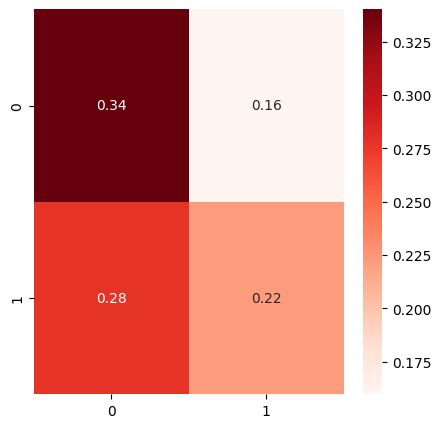

In [86]:
report(y_test, lgbm_best.predict(x_test_selected))

# Результаты

In [87]:
best_models = [rfc_best, xgb_rfc_best, xgb_best, lgbm_best, cb_best]

In [88]:
best_models_cv_metrics = [rfc_best_cv_metrics, xgb_rfc_best_cv_metrics, xgb_best_cv_metrics, lgbm_best_cv_metrics, cb_best_cv_metrics]

In [89]:
def test_results(model, x_test, y_true):
  y_pred = model.predict(x_test)
  round_num = 2
  result_dict = {
      "Accuracy": round(accuracy_score(y_true, y_pred), round_num),
      "AUC": round(roc_auc_score(y_true, y_pred), round_num),
      "Precision": round(precision_score(y_true, y_pred), round_num),
      "Recall": round(recall_score(y_true, y_pred), round_num),
      "F1-score": round(f1_score(y_true, y_pred), round_num),
      "F2-score": round(f2_score(y_true, y_pred), round_num)
  }
  return result_dict

In [90]:
round_num = 2
for metrics in best_models_cv_metrics:
  print("'Accuracy':", round(np.mean(metrics[0]), round_num),"+-",round(np.std(metrics[0]), round_num),",",
        "'AUC':", round(np.mean(metrics[1]), round_num),"+-",round(np.std(metrics[1]), round_num),","
        "'Precision':", round(np.mean(metrics[2]), round_num),"+-",round(np.std(metrics[2]), round_num),","
        "'Recall':", round(np.mean(metrics[3]), round_num),"+-",round(np.std(metrics[3]), round_num),","
        "'F1-score':", round(np.mean(metrics[4]), round_num),"+-",round(np.std(metrics[4]), round_num),","
        "'F2-score':", round(np.mean(metrics[5]), round_num),"+-",round(np.std(metrics[5]), round_num),)

'Accuracy': 0.8 +- 0.02 , 'AUC': 0.87 +- 0.02 ,'Precision': 0.78 +- 0.02 ,'Recall': 0.76 +- 0.03 ,'F1-score': 0.77 +- 0.02 ,'F2-score': 0.76 +- 0.02
'Accuracy': 0.73 +- 0.02 , 'AUC': 0.77 +- 0.02 ,'Precision': 0.7 +- 0.02 ,'Recall': 0.67 +- 0.01 ,'F1-score': 0.68 +- 0.02 ,'F2-score': 0.67 +- 0.02
'Accuracy': 0.74 +- 0.02 , 'AUC': 0.78 +- 0.02 ,'Precision': 0.71 +- 0.03 ,'Recall': 0.68 +- 0.02 ,'F1-score': 0.69 +- 0.02 ,'F2-score': 0.68 +- 0.02
'Accuracy': 0.73 +- 0.01 , 'AUC': 0.77 +- 0.01 ,'Precision': 0.7 +- 0.01 ,'Recall': 0.67 +- 0.01 ,'F1-score': 0.68 +- 0.01 ,'F2-score': 0.68 +- 0.01
'Accuracy': 0.73 +- 0.02 , 'AUC': 0.77 +- 0.02 ,'Precision': 0.7 +- 0.02 ,'Recall': 0.67 +- 0.02 ,'F1-score': 0.68 +- 0.02 ,'F2-score': 0.67 +- 0.02


In [91]:
for model in best_models:
  if model == rfc_best: print(test_results(model, x_val_imp, y_val))
  else: print(test_results(model, x_val_selected, y_val))

{'Accuracy': 0.82, 'AUC': 0.76, 'Precision': 0.69, 'Recall': 0.65, 'F1-score': 0.67, 'F2-score': 0.66}
{'Accuracy': 0.75, 'AUC': 0.67, 'Precision': 0.58, 'Recall': 0.47, 'F1-score': 0.52, 'F2-score': 0.49}
{'Accuracy': 0.77, 'AUC': 0.69, 'Precision': 0.62, 'Recall': 0.5, 'F1-score': 0.55, 'F2-score': 0.52}
{'Accuracy': 0.75, 'AUC': 0.66, 'Precision': 0.57, 'Recall': 0.46, 'F1-score': 0.51, 'F2-score': 0.48}
{'Accuracy': 0.76, 'AUC': 0.66, 'Precision': 0.61, 'Recall': 0.44, 'F1-score': 0.51, 'F2-score': 0.46}


In [92]:
for model in best_models:
  if model == rfc_best: print(test_results(model, x_test_imp, y_test))
  else: print(test_results(model, x_test_selected, y_test))

{'Accuracy': 0.62, 'AUC': 0.62, 'Precision': 0.73, 'Recall': 0.4, 'F1-score': 0.51, 'F2-score': 0.44}
{'Accuracy': 0.59, 'AUC': 0.59, 'Precision': 0.61, 'Recall': 0.49, 'F1-score': 0.54, 'F2-score': 0.51}
{'Accuracy': 0.61, 'AUC': 0.61, 'Precision': 0.63, 'Recall': 0.52, 'F1-score': 0.57, 'F2-score': 0.54}
{'Accuracy': 0.56, 'AUC': 0.56, 'Precision': 0.58, 'Recall': 0.44, 'F1-score': 0.5, 'F2-score': 0.47}
{'Accuracy': 0.6, 'AUC': 0.6, 'Precision': 0.62, 'Recall': 0.5, 'F1-score': 0.56, 'F2-score': 0.52}


In [93]:
import shap
shap.initjs()

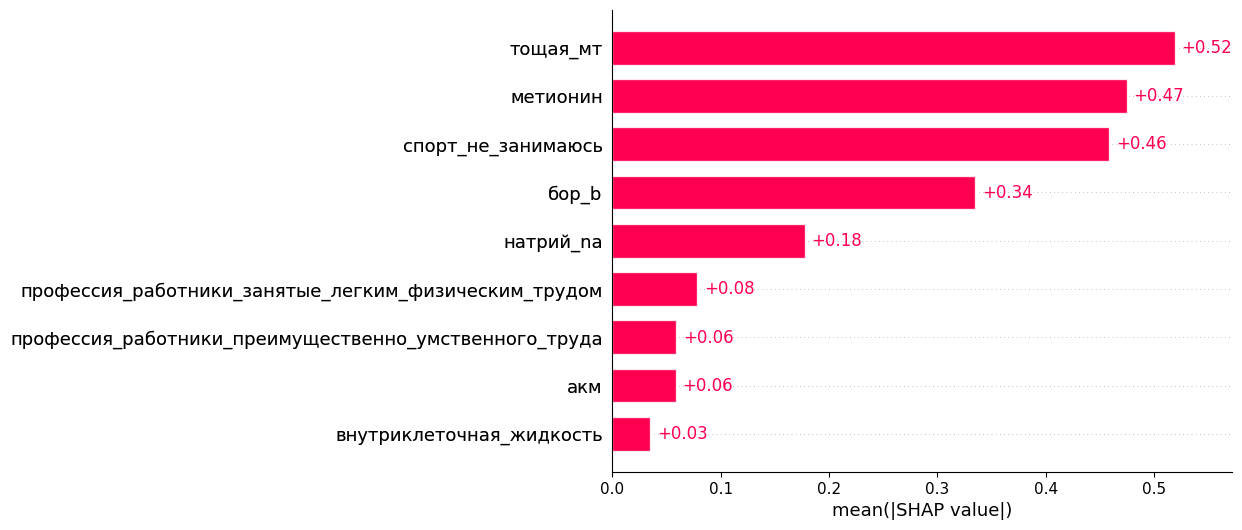

In [94]:
explainer = shap.TreeExplainer(xgb_best)
shap_values = explainer(x_train_selected)
shap.plots.bar(shap_values)

In [95]:
file_names = ["RFClassifier.txt","XGBRFClassifier.txt","XGBoostClassifier.txt","LightGBMClassifier.txt","CatBoostClassifier.txt"]
for i in range(len(best_models)):
    file = open(file_names[i], "w")
    file.write(str(best_models[i].feature_importances_))
    file.close()